# Imports

In [764]:
from PIL import Image, ImageDraw, ImageOps
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import warnings
import concurrent.futures
warnings.filterwarnings("ignore")

# Constants

In [765]:
EDGE_POINTS = 200
STRING_OPACITY = 35 # 0-255
INVERTED = False
CONTRAST = 1.5 # 0-127 
BRIGHTNESS = -126
N_LINES = 2000
IMAGE_DIM = 400
NUM_THREADS = 8
VALUE_OFFSET = 30
g_change_weight = 0.2

In [766]:
g_thread_pool = concurrent.futures.ThreadPoolExecutor(max_workers=NUM_THREADS)
g_image_path = "./images/testcat.png"
g_change_weight = 0.2  # How much the algorithm favours non-white points over white points

# Image Cleaning

##### This step involves creating a circular mask on the image and saving it to the cropped_images folder

In [767]:
image = Image.open(g_image_path)
size = min(image.size)
image = ImageOps.fit(image, (size, size), Image.ANTIALIAS)
width, height = image.size

# Create a circular mask
mask = Image.new('L', image.size, 0)
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, size, size), fill=255)

# Apply circular mask to the image
circular_image = Image.new('RGB', (width, height))
circular_image.paste(image, mask=mask)

# Save or serve the resulting image
output = BytesIO()
output_path = "./cropped_images/"+ g_image_path[9:]
circular_image.save(output, format='PNG')
circular_image.save(output_path, format='PNG')

##### Changes the image to greyscale, resizes it to IMAGE_DIM x IMAGE_DIM, inverts it if needed, changes the contrast, brightness and also the range of values of the image

In [768]:
def image_cleanup(img):
    # Black and White
    output_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Scale the image to 400x400 pixels
    output_img = cv2.resize(output_img, (IMAGE_DIM, IMAGE_DIM))
    
    #Invert the Image
    if INVERTED:
        output_img = cv2.bitwise_not(output_img)

    # Change brightness and contrast
    output_img = cv2.addWeighted(output_img, CONTRAST, output_img, 0, BRIGHTNESS)

    #Reducing the colour range of the image
    r = np.linspace(VALUE_OFFSET,255-VALUE_OFFSET,256)
    for i in range(IMAGE_DIM):
        for j in range(IMAGE_DIM):
            output_img[i][j] = r[output_img[i][j]]

    return output_img

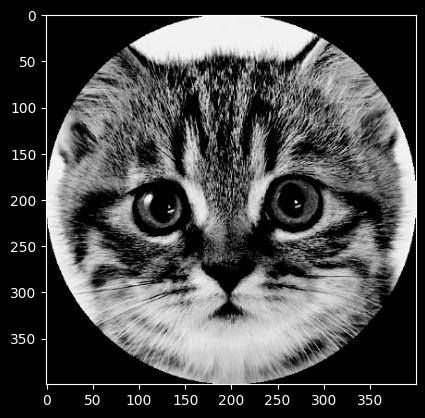

In [769]:
img = cv2.imread(output_path)
img_RGB = img[:,:,::-1]
# plt.imshow(img_RGB)
final_img = image_cleanup(img_RGB)
plt.imshow(final_img,'gray')

The value range minimization isn't shown in the plot

# Defining Edges

##### Defines the edges of the circular canvas with EDGE_POINTS points

In [770]:
def edge_points(img, n):
    points = []
    height, width = img.shape
    # Define circle parameters (adjust these based on your image size)
    center_x = width // 2
    center_y = height // 2
    radius = min(center_x, center_y) - 1  # Ensure the circle is within the image bounds

    # Sample points along the circumference
    theta = np.linspace(0, 2 * np.pi, n)
    edge_points_x = np.uint16(center_x + radius * np.cos(theta))
    edge_points_y = np.uint16(center_y + radius * np.sin(theta))
    edge_points_x = edge_points_x.astype(np.int64)
    edge_points_y = edge_points_y.astype(np.int64)
    return edge_points_x, edge_points_y

def draw_lines(edge_x, edge_y):
    for i in range(0,EDGE_POINTS):
        for j in range(i,EDGE_POINTS):
            xs = [edge_x[i],edge_x[j]]
            ys = [edge_y[i],edge_y[j]]
            plt.plot(xs, ys,color='black',lw = 0.1)

edge_x, edge_y = edge_points(final_img, EDGE_POINTS)

# Bresenham's Line Algorithm

##### Generate the intermediate points between every start and end combination, stored in a dictionary

In [771]:
def bresenham(x1, y1, x2, y2, swap=False, neg_y=False):
    if y2 < y1 and not neg_y:
        return bresenham(x1, y1, x2, y2, swap=swap, neg_y=True)
    if x2 < x1:
        return bresenham(x2, y2, x1, y1, swap=swap)[::-1]
    line = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    if dy > dx:
        return bresenham(y1, x1, y2, x2, swap=True)
    P = 2 * dy - dx
    while x <= x2:
        if swap:
            line.append((y, x))
        else:
            line.append((x, y))
        x += 1
        if P < 0:
            P = P + 2 * dy
        else:
            P = P + 2 * dy - 2 * dx
            if neg_y:
                y -= 1
            else:
                y += 1
    return line

In [772]:
def create_database(edge_x,edge_y):
    line_dict = dict()
    for i in range(0,EDGE_POINTS): # for every edge point
        for j in range(i+1,EDGE_POINTS): # go to all the others,
            
            # Calculate intermediate points with bresenham
            points = [(edge_x[i],edge_y[i]), (edge_x[j],edge_y[j])]  
            x1, y1 = points[0][0], points[0][1]
            x2, y2 = points[1][0], points[1][1]
            if not f"{x1},{y1}" in line_dict: line_dict[f"{x1},{y1}"] = dict()
            if not f"{x2},{y2}" in line_dict: line_dict[f"{x2},{y2}"] = dict()
            
            tmp = bresenham(x1,y1,x2,y2)
            line_dict[f"{x1},{y1}"][f"{x2},{y2}"] = tmp
            line_dict[f"{x2},{y2}"][f"{x1},{y1}"] = tmp
    return line_dict

line_dict = create_database(edge_x,edge_y)

# Greedy Simulation

##### Picks the best line at every iteration based on the error() function.
The simulation adds the STRING_OPACITY value to each of the intermediate points before taking the absolute difference between the working canvas and the image. 'change' is used to encourage the algorithm to draw over different pixels instead of ones that are already at 255

In [773]:
def error(img,canvas,change):
    return np.sum(np.sum(abs(img-canvas))) - change

def mutate_canvas(xs,ys,temp_canvas):
    prev_value = temp_canvas[xs,ys]
    mask = (255-(prev_value + STRING_OPACITY))>>31
    temp_canvas[xs,ys] = ((~mask&0xFF) & (STRING_OPACITY + prev_value)) | (mask & 0xFF) 
    return temp_canvas[xs,ys] - prev_value

def try_line(points,current_canvas,img):
    change = 0
    temp_canvas = np.copy(current_canvas)
    xs,ys = zip(*points)
    xs,ys = np.array(xs), np.array(ys)
    change += np.sum(mutate_canvas(xs,ys,temp_canvas))
    
    return error(img,temp_canvas,change*g_change_weight), temp_canvas

In [774]:
def get_new_canvas(start, key, value, current_canvas, img):
    current_error, temp_canvas = try_line(line_dict[start][key], current_canvas,img)
    return current_error,temp_canvas,key

In [775]:
def pick_next_point(start,current_canvas, img, line_dict):
    best_line = random.choice(list(line_dict[start].keys())) # Initialize to random edge point
    best_error = try_line(line_dict[start][best_line],current_canvas,img)[0]
    new_canvas = current_canvas
    
    for future in concurrent.futures.as_completed([g_thread_pool.submit(get_new_canvas,start, key, value, current_canvas,img) for key,value in line_dict[start].items()]):
        current_error, temp_canvas, key = future.result()
        if current_error < best_error:
            best_error = current_error
            best_line = key
            new_canvas = temp_canvas

    return best_line, new_canvas

In [776]:
def sim(n, img):
    global g_change_weight
    start = next(iter(line_dict)) # Picks the first element from the line_dict
    start_x, start_y = start.split(',') 
    xs = [int(start_x)]
    ys = [int(start_y)]
    current_canvas = np.zeros_like(img)
    for i in range(n):
        point, new_canvas = pick_next_point(start, current_canvas, img, line_dict)
        start = point
        x, y = point.split(',')
        xs.append(int(x))
        ys.append(int(y))
        current_canvas = new_canvas
    return current_canvas,np.array(xs),np.array(ys)

In [777]:
image = np.array(np.array(final_img).tolist())
finished_canvas, xs,ys = sim(N_LINES, image)

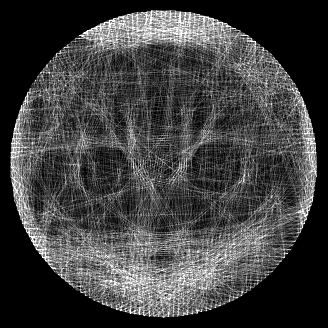

In [778]:
plt.figure(figsize=(4,4))
plt.style.use('dark_background')
plt.plot(ys,-xs,'white',lw=0.05,alpha=1)
plt.gca().set_aspect('equal')
plt.xlim(0,400)
plt.ylim(-400,0)
plt.axis('off') 
output_path = "./output_images/"+ g_image_path[9:]
plt.savefig(output_path,bbox_inches='tight', pad_inches=0)
plt.show()

In [779]:
g_thread_pool.shutdown(wait=True)